In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
from optparse import OptionParser
import sys
from time import time
from sklearn.datasets import fetch_20newsgroups

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [248]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s %(Levelname)s %(message)s')

op = OptionParser()
op.add_option("--report", action ="store_true", dest ="print_report", help="Print a detailed classification report")
op.add_option("--chi2_select", action ="store", type="int", dest ="select_chi2", help ="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix", action ="store_true", dest="print_cm", help="Print the confusion matrix")
op.add_option("--top 10", action ="store_true", dest="print_top10", help="Print ten most discriminative terms per class" "for every classifier")
op.add_option("--all_categories", action="store_true", dest="all_categories", help="Whether to use all categories or not")
op.add_option("--use_hashing", action="store_true", help="use a hashing vectorizer")
op.add_option("--n_features", action="store", type=int, default = 2 ** 16, help = "n_features when using the Hashing vectorizer")
op.add_option("--filtered", action="store_true", help="remove information that is easily overfit:" "headers, signatures, and quoting")

def is_interactive():
    return not hasattr(sys.modules['__main__'],'__file__')

argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no argument.")
    sys.exit(1)
    
print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix
  --top 10              Print ten most discriminative terms per classfor every
                        classifier
  --all_categories      Whether to use all categories or not
  --use_hashing         use a hashing vectorizer
  --n_features=N_FEATURES
                        n_features when using the Hashing vectorizer
  --filtered            remove information that is easily overfit:headers,
                        signatures, and quoting



In [249]:
if opts.all_categories:
    categories = None
else:
    categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
    
if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else: 
    remove =()
    
print('Loading 20 newsgroup datasets for categories:')
print(categories if categories else 'all')

data_train = fetch_20newsgroups(subset ='train', categories = categories, shuffle = True, random_state =42, remove = remove)

data_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=remove)

print('data loaded')

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 992, in emit
    msg = self.format(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 838, in format
    return fmt.format(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 578, in format
    s = self.formatMessage(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 547, in formatMessage
    return self._style.format(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 391, in format
    return self._fmt % record.__dict__
KeyError: 'Levelname'
Call stack:
  File "C:\Users\zenit\.julia\conda\3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\zenit\.julia\conda\3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\zenit\.julia\conda\3\lib\site-packages\ipykernel_launcher.py", line 16, in <modu

Loading 20 newsgroup datasets for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 992, in emit
    msg = self.format(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 838, in format
    return fmt.format(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 578, in format
    s = self.formatMessage(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 547, in formatMessage
    return self._style.format(record)
  File "C:\Users\zenit\.julia\conda\3\lib\logging\__init__.py", line 391, in format
    return self._fmt % record.__dict__
KeyError: 'Levelname'
Call stack:
  File "C:\Users\zenit\.julia\conda\3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\zenit\.julia\conda\3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\zenit\.julia\conda\3\lib\site-packages\ipykernel_launcher.py", line 16, in <modu

data loaded


In [125]:
#data_train

In [265]:
data_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [280]:
string = "I am a boy"
print(1e6)
len(string.encode('utf-8'))/1e6

1000000.0


1e-05

In [282]:
len(data_train.data)

2034

In [273]:
data_train.data[0]

"From: rych@festival.ed.ac.uk (R Hawkes)\nSubject: 3DS: Where did all the texture rules go?\nLines: 21\n\nHi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych\n\n======================================================================\nRycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\nVirtual Environment Laboratory\nDept. of Psychology\t\t\tTel  : +44 31 650 3426\nUniv. of Edinburgh\t\t\tFax  : +44 31 667 0150\n==============

In [276]:
len(data_train.data[0].encode('utf-8'))

1022

In [281]:
data_train_size_mb

3.979536

In [283]:
data_train.target

array([1, 3, 2, ..., 1, 0, 1], dtype=int64)

In [251]:
target_names = data_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs)/1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" %(len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" %(len(data_test.data), data_test_size_mb))
print("%d categories"% len(target_names))
print()

y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using sparse vectorizer")

t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign = False, n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer=TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
    
duration = time() - t0
print('done in %fs at %0.3fMB/s' %(duration, data_train_size_mb/duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb/duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()
    
if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" % opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k = opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        feature_names = [feature_names[i] for i in ch2.get_support(indices = True)]
    print("done in %fs" % (time() - t0))
    print()
    
if feature_names:
    feature_names = np.asarray(feature_names)
    
def trim(s):
    return s if len(s) <= 80 else s[:77] + "..."

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using sparse vectorizer
done in 0.456778s at 8.712MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.313166s at 9.156MB/s
n_samples: 1353, n_features: 33809



In [258]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time: %0.3fs" % test_time)
    
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy: %0.3f" % score)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        
        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class: ")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()
    
    if opts.print_report:
        print("Classification report")
        print(metrics.classification_report(y_test, pred, target_names=target_names))
        
    if opts.print_cm:
        print("confusion_matrix: ")
        print(metrics.confusion_matrix(y_test, pred))
        
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

results = []
for clf, name in ((RidgeClassifier(tol =1e-2, solver="sag"), "Ridge Classifier"),
                 (Perceptron(max_iter=50), "Perceptron"),
                 (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"), 
                 (KNeighborsClassifier(n_neighbors=10), 'kNN'), 
                 (RandomForestClassifier(), "Random Forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

# Train SGD with Elastic Net penalty
print('=' * 80)
print('Elastic-Net penalty')
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty='elasticnet')))

# Train nearest centroid without threshold
print('=' * 80)
print('NearestCentroid(aka Rocchio classifier)')
results.append(benchmark(NearestCentroid()))

#Train sparse Naive Bayes classifier
print('=' * 80)
print('Naive Bayes')

results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha = 0.1)))
    
    
print('=' * 80)
print("Linear SVC with L1 based feature selection")

results.append(benchmark(Pipeline([('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual = False, tol=1e-3))), 
                                  ('classification', LinearSVC(penalty='l2'))])))
    
for penalty in ['12', '11']:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual = False, tol = 1e-3)))
    
    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty = penalty)))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.174s
test time: 0.007s
accuracy: 0.897
dimensionality: 33809


C:\Users\zenit\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.021s
test time: 0.002s
accuracy: 0.888
dimensionality: 33809
density: 0.255302


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                        

ValueError: Unsupported set of arguments: The combination of penalty='12' and loss='squared_hinge' is not supported, Parameters: penalty='12', loss='squared_hinge', dual=False

# Competition

### Get training data

In [3]:
train = pd.read_csv("C:/Users/zenit/Desktop/Sahal backup/Northeastern University/Datasets/AV identify sentiments/train.csv")

### How does my data look?

In [4]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
train.shape

(7920, 3)

## See a negative tweet

In [6]:
train.tweet[4]

"What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!"

### We have 5894 positive tweets and 2026 negative tweets

In [103]:
train.label.value_counts()*100/len(train.label)

0    74.419192
1    25.580808
Name: label, dtype: float64

## Class imbalance

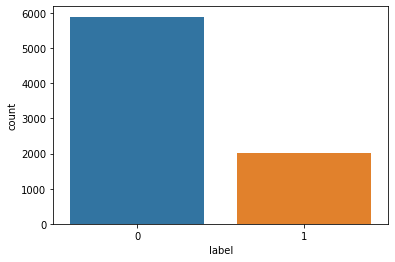

In [101]:
sns.countplot(train.label)

## Check the tweet text

In [121]:
index = 176
example = train[train.index == index][['tweet', 'label']].values[0]
if len(example) > 0:
    print(example[0])

New iPhone OS on the 3G FUCKING SUCKS. I WANT TO THROW MY PHONE AGAINST THE WALL. HOW DOES THE SMS "APP" crash!?! #apple #iphone


## Text preprocessing

In [ ]:
### Convert all text to lowercase
### Replace replace_by_space_re symbols by space in text
### Remove symbols that are in Bad_Symbol_RE from text

## Get labels

In [7]:
labels = train.label
labels.head()

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: int64

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train['tweet'], labels, test_size = 0.15, random_state = 1)

In [9]:
x_train.shape

(6732,)

In [10]:
x_test.shape

(1188,)

## Convert abstracts into word count vectors

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

## Initialize the Count vectorizer

In [12]:
cv = CountVectorizer(strip_accents = 'ascii', lowercase = True, stop_words = 'english', token_pattern = u'(?ui)\\b\\w*[a-z]+\\w*\\b')

### Transform the train and validation file

In [13]:
X_train_cv = cv.fit_transform(x_train)
X_test_cv = cv.transform(x_test)

### Create a data frame to view your vectorized data 

In [14]:
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns = cv.get_feature_names())

top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending = False)

In [15]:
word_freq_df

,00am,00pm,01108nartl,01am,01amapril,01amjune,01ammay,01pm,01pmapril,01pmjune,...,zyuirs1wadbou,zyvwiyhtzm,zz7xpxpqmwkt,zz86j,zz96a_jep6,zzhb7x12hn6wg,zzita3co0x,zzjvgtyaxl,zznj908fjw,zznnb2inkt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Create Naive Bayes model

In [87]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

# Multinomial NB
#naive_bayes = MultinomialNB(alpha = 0.1)

# Bernoulli NB
naive_bayes = BernoulliNB(alpha = 0.63)

# Complement NB
#naive_bayes = ComplementNB(alpha = 0.085)

naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

#Gaussian NB here
# gnb = GaussianNB(alpha = 0.1)
# y_pred = gnb.fit(X_train_cv.toarray(), y_train).predict(X_test_cv.toarray())

## Check accuracy

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_score(y_test, predictions)

#accuracy_score(y_test, y_pred)


#precision_score(y_test, predictions)
#recall_score(y_test, predictions)

0.8930976430976431

In [53]:
prediction1 = pd.DataFrame(predictions)

In [31]:
naive_bayes.predict_proba(X_test_cv)[4]

array([2.30474126e-04, 9.99769526e-01])

## Create confusion matrix

Text(51.0, 0.5, 'True label')

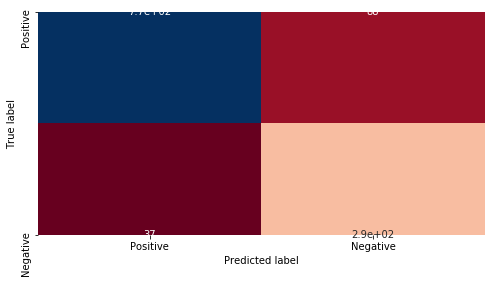

In [21]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square = True, annot = True, cmap = 'RdBu', cbar = False, 
            xticklabels = ['Positive', 'Negative'], yticklabels = ['Positive', 'Negative'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [22]:
y_test.value_counts()

0    859
1    329
Name: label, dtype: int64

In [23]:
cm

array([[771,  88],
       [ 37, 292]], dtype=int64)

## Check which are wrong labels

In [24]:
testing_predictions = []

for i in range(len(y_test)):
    if predictions[i] == 1:
        testing_predictions.append(1)
    else:
        testing_predictions.append(0)

check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'abstract':list(x_test)})
check_df.replace(to_replace=0, value= 'Positive', inplace=True)
check_df.replace(to_replace=1, value= 'Negative', inplace=True)

In [25]:
check_df

,actual_label,prediction,abstract
0,Positive,Positive,I love simsimi! #simsimi #me #iphone #app #awe...
1,Negative,Negative,@SamsungMobile #yousuck Worst mobiles with wor...
2,Positive,Positive,#Beauty #Shopping #AliUSAExpress #iPhone #ios ...
3,Positive,Negative,"Well, well, what do we have here? #Google #And..."
4,Positive,Negative,running 10.5.7 and everything looks fine! my i...
...,...,...,...
1183,Positive,Positive,Got some much needed time w baby Nolan and mam...
1184,Negative,Negative,"...and spell check if I mistyped ""quickest"" ho..."
1185,Positive,Negative,Only reason I'd get an iPhone is b/c of all th...
1186,Positive,Positive,#happiness is #new #gadget #gift fromm #brothe...


In [62]:
np.where(check_df.actual_label != check_df.prediction)

(array([   4,    9,   15,   24,   27,   36,   69,   70,   74,   78,   89,
          93,  102,  107,  109,  131,  140,  145,  161,  165,  172,  182,
         185,  192,  195,  203,  208,  216,  221,  227,  237,  238,  240,
         242,  253,  280,  282,  292,  300,  306,  312,  315,  333,  343,
         344,  348,  353,  360,  368,  377,  381,  384,  389,  392,  401,
         408,  420,  423,  424,  454,  455,  468,  482,  494,  512,  515,
         528,  559,  560,  568,  581,  590,  594,  596,  597,  606,  607,
         614,  618,  629,  632,  640,  644,  670,  674,  685,  722,  723,
         735,  746,  748,  764,  775,  781,  784,  800,  802,  817,  827,
         832,  849,  853,  857,  860,  861,  872,  874,  879,  888,  891,
         893,  905,  922,  931,  955,  965,  976, 1018, 1020, 1028, 1031,
        1038, 1043, 1062, 1065, 1077, 1079, 1089, 1103, 1122, 1130, 1151],
       dtype=int64),)

## Evaluate the Test data

In [ ]:
test = pd.read_csv("C:/Users/zenit/Desktop/Sahal backup/Northeastern University/Datasets/AV identify sentiments/test.csv")
test1 = test['tweet']
cv_test = cv.transform(test1)
y_pred_nb = naive_bayes.predict(cv_test)
pred = pd.DataFrame(y_pred_nb)
pred.to_csv("C:/Users/zenit/Desktop/Sahal backup/Northeastern University/Datasets/AV identify sentiments/predict2.csv")


# Practice

In [286]:
doc = ["the house had a tiny little mouse",
      "the cat saw the mouse",
      "the mouse ran away from the house",
      "the cat finally ate the mouse",
      "the end of the mouse story"]

In [292]:
# vectorizer = HashingVectorizer(stop_words='english', alternate_sign = False, n_features=opts.n_features)
# doc_train_hash = vectorizer.transform(doc)

vectorizer=TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
doc_train_vect = vectorizer.fit_transform(doc)

In [294]:
doc_train_hash.shape

(5, 65536)

In [297]:
doc_train_hash.get_feature_names_

AttributeError: get_feature_names_ not found

In [293]:
doc_train_vect

<5x11 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [67]:
cv = CountVectorizer()
word_count_vectorizer = cv.fit_transform(doc)

In [68]:
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.

counting the occurrences of tokens in each document.

normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In this scheme, features and samples are defined as follows:

each individual token occurrence frequency (normalized or not) is treated as a feature.

the vector of all the token frequencies for a given document is considered a multivariate sample.

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [52]:
word_count_vectorizer

<5x16 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [53]:
word_count_vectorizer.shape

(5, 16)

In [95]:
word_count_vectorizer.toarray()

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0]], dtype=int64)

In [92]:
analyze = cv.build_analyzer()
analyze("the dog the sentence") == (["the", "dog", "the", "sentence"])

True

In [94]:
cv.get_feature_names()

['ate',
 'away',
 'cat',
 'end',
 'finally',
 'from',
 'had',
 'house',
 'little',
 'mouse',
 'of',
 'ran',
 'saw',
 'story',
 'the',
 'tiny']

In [100]:
#The converse mapping from feature name to column index is stored in the vocabulary_ attribute of the vectorizer:

cv.vocabulary_.get('mouse')

9

In [103]:
cv.transform(["mouse"]).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [147]:
bigram_vectorizer = CountVectorizer(ngram_range = (1,2), token_pattern = r'\b\w+\b', min_df = 1)
analyze = bigram_vectorizer.build_analyzer()
analyze("Bi-grams are cool") == (["b", "grams", "are", "cool", "bi-grams", "grams are", "are cool"])

False

In [148]:
X_2 = bigram_vectorizer.fit_transform(doc).toarray()

X_2

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0]], dtype=int64)

In [149]:
bigram_vectorizer.get_feature_names()

['a',
 'a tiny',
 'ate',
 'ate the',
 'away',
 'away from',
 'cat',
 'cat finally',
 'cat saw',
 'end',
 'end of',
 'finally',
 'finally ate',
 'from',
 'from the',
 'had',
 'had a',
 'house',
 'house had',
 'little',
 'little mouse',
 'mouse',
 'mouse ran',
 'mouse story',
 'of',
 'of the',
 'ran',
 'ran away',
 'saw',
 'saw the',
 'story',
 'the',
 'the cat',
 'the end',
 'the house',
 'the mouse',
 'tiny',
 'tiny little']

### The lower the IDF value of a word, the less unique it is to any particular document.

In [54]:
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf=True)
tfidf_transformer.fit(word_count_vectorizer)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [55]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(), columns=['idf_weights'])
df_idf.sort_values(by=["idf_weights"])

,idf_weights
mouse,1.000000
the,1.000000
cat,1.693147
house,1.693147
ate,2.098612
away,2.098612
end,2.098612
finally,2.098612
from,2.098612
had,2.098612


In [58]:
count_vector = cv.transform(doc)
count_vector

<5x16 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [60]:
tf_idf_vector = tfidf_transformer.transform(count_vector)

In [64]:
print(tf_idf_vector[0])

  (0, 15)	0.4935620852501244
  (0, 14)	0.23518497814732847
  (0, 9)	0.23518497814732847
  (0, 8)	0.4935620852501244
  (0, 7)	0.39820278266020154
  (0, 6)	0.4935620852501244


In [62]:
feature_names = cv.get_feature_names()
first_document_vector = tf_idf_vector[0]
df = pd.DataFrame(first_document_vector.T.todense(), index = feature_names, columns = ["tfidf"])
df.sort_values(by=["tfidf"], ascending = False)

,tfidf
had,0.493562
little,0.493562
tiny,0.493562
house,0.398203
mouse,0.235185
the,0.235185
ate,0.000000
away,0.000000
cat,0.000000
end,0.000000


In [229]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7, smooth_idf = True)#, #ngram_range = (1,4), )

In [232]:
a = tfidf_vectorizer.fit_transform(doc)
tfidf_vectorizer.idf_

array([2.09861229, 2.09861229, 1.69314718, 2.09861229, 2.09861229,
       1.69314718, 2.09861229, 2.09861229, 2.09861229, 2.09861229,
       2.09861229])

In [233]:
a.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.49552379, 0.61418897, 0.        , 0.        , 0.        ,
        0.61418897],
       [0.        , 0.        , 0.62791376, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.77828292, 0.        ,
        0.        ],
       [0.        , 0.61418897, 0.        , 0.        , 0.        ,
        0.49552379, 0.        , 0.61418897, 0.        , 0.        ,
        0.        ],
       [0.61418897, 0.        , 0.49552379, 0.        , 0.61418897,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.70710678, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.70710678,
        0.        ]])

In [226]:
tfidf_vectorizer.get_feature_names()

['ate',
 'away',
 'cat',
 'end',
 'finally',
 'house',
 'little',
 'ran',
 'saw',
 'story',
 'tiny']

In [176]:
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=None,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [204]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

In [153]:
x_train.shape

(5544,)

In [162]:
tfidf_train

<5544x172956 sparse matrix of type '<class 'numpy.float64'>'
	with 276857 stored elements in Compressed Sparse Row format>

In [46]:
type(tfidf_train)

scipy.sparse.csr.csr_matrix

In [155]:
tfidf_train.shape

(5544, 65749)

In [156]:
print(tfidf_train)

  (0, 55293)	0.21491437038138658
  (0, 46757)	0.20515349305213257
  (0, 28256)	0.20515349305213257
  (0, 10913)	0.16985394207816215
  (0, 56007)	0.1982280403735304
  (0, 5145)	0.21491437038138658
  (0, 31542)	0.12611092191201465
  (0, 32448)	0.20515349305213257
  (0, 63173)	0.21491437038138658
  (0, 11277)	0.21491437038138658
  (0, 11223)	0.21491437038138658
  (0, 41903)	0.21491437038138658
  (0, 35554)	0.21491437038138658
  (0, 50327)	0.21491437038138658
  (0, 21361)	0.21491437038138658
  (0, 2401)	0.21491437038138658
  (0, 55292)	0.1982280403735304
  (0, 46755)	0.1928562419434394
  (0, 28158)	0.0446579384186658
  (0, 10863)	0.1092746021008594
  (0, 56003)	0.12932546125695063
  (0, 4386)	0.05091884164387218
  (0, 31494)	0.04407297014700945
  (0, 32435)	0.14340673474105192
  (0, 63137)	0.12354447531723062
  :	:
  (5543, 53088)	0.2375408217932295
  (5543, 18185)	0.2375408217932295
  (5543, 3074)	0.2375408217932295
  (5543, 53476)	0.2375408217932295
  (5543, 48118)	0.2375408217932295
  (

In [158]:
x_test.shape

(2376,)

In [157]:
tfidf_test

<2376x65749 sparse matrix of type '<class 'numpy.float64'>'
	with 38619 stored elements in Compressed Sparse Row format>

In [206]:
pac = PassiveAggressiveClassifier(max_iter = 200)
pac.fit(tfidf_train, y_train)

y_pred = pac.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)

score

0.8888888888888888

In [208]:
confusion_matrix(y_test, y_pred)

array([[794,  65],
       [ 67, 262]], dtype=int64)

In [89]:
test = pd.read_csv("C:/Users/zenit/Desktop/Sahal backup/Northeastern University/Datasets/AV identify sentiments/test.csv")

In [56]:
test

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...
...,...,...
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old..."
1949,9870,Now Available - Hoodie. Check it out here - ht...
1950,9871,There goes a crack right across the screen. If...
1951,9872,@codeofinterest as i said #Adobe big time we m...


In [90]:
test1 = test['tweet']

In [91]:
cv_test = cv.transform(test1)

In [58]:
tfidf_test1 = tfidf_vectorizer.transform(test1)

NameError: name 'tfidf_vectorizer' is not defined

In [211]:
tfidf_test1

<1953x206161 sparse matrix of type '<class 'numpy.float64'>'
	with 40301 stored elements in Compressed Sparse Row format>

In [212]:
y_pred_test = pac.predict(tfidf_test1)

In [92]:
y_pred_nb = naive_bayes.predict(cv_test)

In [93]:
pred = pd.DataFrame(y_pred_nb)

In [213]:
pred = pd.DataFrame(y_pred_test)

In [215]:
pred

,0
0,1
1,0
2,1
3,1
4,1
...,...
1948,0
1949,0
1950,1
1951,1


In [94]:
pred.to_csv("C:/Users/zenit/Desktop/Sahal backup/Northeastern University/Datasets/AV identify sentiments/predict2.csv")